In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Libraries**

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLP libraries and files
import nltk
import string
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from IPython.display import Markdown, display, clear_output

def printBold(str):
    display(Markdown('**' + str + '**'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# (1) Data Collection

**Import dataset**

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Data/combinedData.csv')
df.pop('id')
df.pop('Unnamed: 0')
df['text'] = df['text'].astype(str)

**View the dataset**

In [ ]:
dfDisplay = df
dfDisplay['label'] = dfDisplay['label'].map({1: '1 (Real)', 0: '0 (Fake)'})
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 1000)
dfDisplay[['title', 'text', 'label']].head()

,title,text,label
0,Democrat sees bipartisan support for corporate tax reform,"WASHINGTON (Reuters) - U.S. President Donald Trump could find Democratic support for a corporate tax reform package if a comprehensive tax code overhaul runs aground over Republican infighting, a Democratic lawmaker told Reuters on Friday. Representative John Yarmuth, top Democrat on the House of Representatives Budget Committee, predicted Trump’s promise to deliver the biggest tax reform since Ronald Reagan would have to be scaled back if the Republican-controlled Senate fails next week to adopt legislation dismantling Obamacare, formally known as the Affordable Care Act. The Trump administration and Republican congressional leaders are trying to agree in closed-door talks on a comprehensive 2017 tax reform bill that would cut taxes for individuals and businesses and overhaul the U.S. tax code. Their aim is to unveil legislation in September. But a Republican effort to dismantle the Affordable Care Act, which would could ease the path to tax reform, faces difficulties in the Sena...",1 (Real)
1,U.S. budget deficit to reach $600 billion in 2016: White House,"WASHINGTON (Reuters) - The U.S. budget deficit is projected to rise to $600 billion in 2016, $16 billion less than previously expected, the White House Office of Management and Budget said on Friday. In a mid-session review, the administration said the 2016 deficit is now projected to be 3.3 percent of Gross Domestic Product (GDP).",1 (Real)
2,Fox Host Already Using Tragic EgyptAir Crash As A Way To Boost Trump (VIDEO),"Just when you think the right-wing shills at Fox News couldn t possibly get anymore despicable, they go and do just that. By now, everyone has heard of the tragic crash of EgyptAir flight 804 in the vicinity of the Mediterranean Sea after it disappeared from the radar Wednesday night en route from Paris to Cairo. While the rest of the world is reeling from this tragic event, Fox Business host Stuart Varney is busy trying turn it into a way to help elect Donald Trump.Appearing on Fox and Friends less than 24 hours later, Varney insisted that this plane crash would somehow encourage the refugee crisis. He went on to say: I also think this may be good politically for Donald Trump. He s already tweeted out, saying this is probably terrorism.He s the guy who is saying, hands off, keep Muslims out temporarily whist we figure out who comes in. An incident of this type is surely a plus for Donald Trump. So, in other words, it seems that this imbecile is actually glad that this plane crash...",0 (Fake)
3,Trump Just Lost His Damn Mind On Twitter After Bernie Endorsed Hillary (TWEETS),"After finding out that Senator Bernie Sanders (I-VT) was endorsing Hillary Clinton for president on Tuesday morning, Donald Trump took to Twitter, as he always does, to try to lure in as many angry Bernie supporters as possible. He put out such a tweet storm that it actually appeared that he lost his damn mind more than he already likely has.In a series of tweets, Trump showed how desperately he is trying to pander to Bernie Sanders voters who are mad at the Senator from Vermont for endorsing Hillary Clinton. It s so obvious, in fact, that he s trying to play to that crowd, that if it works, it probably says more about those who could so easily switch to the anti-Bernie that is Trump, than it actually says about Trump himself.He tweeted:Bernie Sanders, who has lost most of his leverage, has totally sold out to Crooked Hillary Clinton. He will endorse her today fans angry! Donald J. Trump (@realDonaldTrump) July 12, 2016I am somewhat surprised that Bernie Sanders was not true to ...",0 (Fake)
4,HOLLYWOOD RACE WAR HEATS UP: Full Metal Jacket Actor SHUTS DOWN Race-Baiting Hotel Rwanda Star,"Nice job Adam Baldwin. We commend you for standing up to the highly successful, black multi-millionaires Jada Pinkett-Smith, her husband Will Smith and Director Spike Lee who, much like Al Sharpton never lets the opportunity 

**Display distribution**

Text(0.5, 1.0, 'Fake vs Real News')

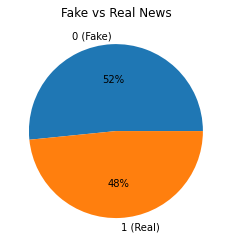

In [ ]:
ax = df['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', labels=['0 (Fake)','1 (Real)'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Fake vs Real News')

# (2) Data Preparation

**Remove location, publisher, URLs**

In [ ]:
def removeLocPubURL(df):
    fullText = []
    publisher = []
    for txt in (range(len(df))):
        text = df.iloc[txt].text
        try:
            splitText = text.split(" -", maxsplit=1)
            splitText[1] = re.sub(r'^https?:\/\/.*[\r\n]*', '', splitText[1], flags=re.MULTILINE)
            fullText.append(splitText[1])
            publisher.append(splitText[0])
        except:
            fullText.append(text)
            publisher.append('')

    return fullText

df['text'] = removeLocPubURL(df)

**Remove punctuation**

Examples: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [ ]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        
        text = text.replace(punctuation, '')
    return text

df['text'] = df['text'].apply(remove_punctuations)

**Remove stop words**

Examples: 

'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",

In [ ]:
def remove_stop_words(text):
    for word in stopwords.words('english'):
        word = ' ' + word + ' '
        text = text.replace(word, ' ')
    return text

df['text'] = df['text'].apply(remove_stop_words)

**Convert text to lowercase**

In [ ]:
def lowerCase(df):
    return df['text'].str.lower()

df['text'] = lowerCase(df)

**Lemmatization**

Example: 
**studies, studying, studied** turns into the lemma - **study**

In [ ]:
def lemmatization(text):
    final_text = []
    lemma = nltk.WordNetLemmatizer()
    text = nltk.word_tokenize(text)
    for word in text: 
        wordAppend = lemma.lemmatize(word)
        final_text.append(wordAppend)
    return ' '.join(final_text)

df['text'] = df['text'].apply(remove_stop_words)

**Split dataset into training, validation, and testing**

In [ ]:
y = df.pop('label')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, shuffle=True)

X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42, shuffle=True)

print('---------------------------------------------')
print('Total Samples:', len(y))
print('---------------------------------------------')
print('Training Samples:', len(X_train))
print('Validation Samples:', len(X_validation))
print('Testing Samples:', len(X_test))

---------------------------------------------
Total Samples: 65698
---------------------------------------------
Training Samples: 39418
Validation Samples: 13140
Testing Samples: 13140


**Data preprocessing**

In [ ]:
vocabSize = 15000
embeddingDim = 32
maxLength = 300
paddingType='post'
truncType='post'
oovToken = "<OOV>"

tokenizer = Tokenizer(num_words=vocabSize, oov_token=oovToken)
tokenizer.fit_on_texts(X_train.text)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train.text)
training_padded = pad_sequences(training_sequences, maxlen=maxLength, padding=paddingType, truncating=truncType)

validation_sequences = tokenizer.texts_to_sequences(X_validation.text)
validation_padded = pad_sequences(validation_sequences, maxlen=maxLength, padding=paddingType, truncating=truncType)

test_sequences = tokenizer.texts_to_sequences(X_test.text)
test_padded = pad_sequences(test_sequences, maxlen=maxLength, padding=paddingType, truncating=truncType)

# (3) Choosing a model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabSize, output_dim=embeddingDim, input_length=maxLength),
    tf.keras.layers.LSTM(128, return_sequences=True), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64), 

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 32)           480000    
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          82432     
_________________________________________________________________
dropout (Dropout)            (None, 300, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 613,953
Trainable params: 613,953
Non-trainable params: 0
__________________________________________________

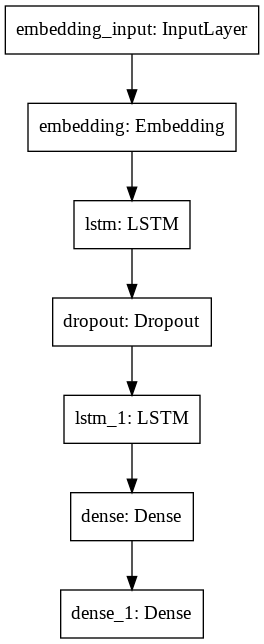

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=False)

# (4) Training

In [ ]:
epochs = 15
history = model.fit(training_padded, y_train, epochs=epochs, validation_data=(validation_padded, y_validation), batch_size=256, shuffle=True, verbose=1)

Epoch 1/15
154/154 [==============================] - 16s 72ms/step - loss: 0.6620 - accuracy: 0.5949 - val_loss: 0.6181 - val_accuracy: 0.6500
Epoch 2/15
154/154 [==============================] - 10s 67ms/step - loss: 0.6221 - accuracy: 0.6561 - val_loss: 0.5162 - val_accuracy: 0.7492
Epoch 3/15
154/154 [==============================] - 10s 67ms/step - loss: 0.3739 - accuracy: 0.8410 - val_loss: 0.6622 - val_accuracy: 0.5572
Epoch 4/15
154/154 [==============================] - 10s 66ms/step - loss: 0.4004 - accuracy: 0.7809 - val_loss: 0.1115 - val_accuracy: 0.9650
Epoch 5/15
154/154 [==============================] - 10s 67ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.0634 - val_accuracy: 0.9796
Epoch 6/15
154/154 [==============================] - 10s 67ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0686 - val_accuracy: 0.9801
Epoch 7/15
154/154 [==============================] - 10s 67ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.1403 - val_accuracy:

**Plot training results**

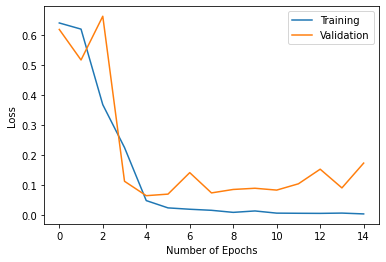

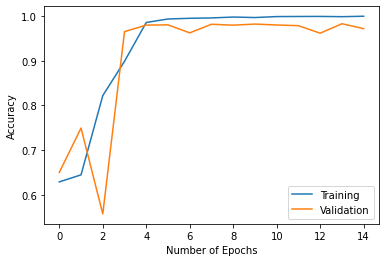

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# (5) Evaluation

In [ ]:
print("Training Data Accuracy: " + str(round(model.evaluate(training_padded, y_train)[1]*100, 2)) + "%")
print("Validation Data Accuracy: " + str(round(model.evaluate(validation_padded, y_validation)[1]*100, 2)) + "%")
printBold("Testing Data Accuracy: " + str(round(model.evaluate(test_padded, y_test)[1]*100, 2)) + "%")

1232/1232 [==============================] - 15s 12ms/step - loss: 0.0542 - accuracy: 0.9918
Training Data Accuracy: 99.18%
411/411 [==============================] - 5s 12ms/step - loss: 0.1721 - accuracy: 0.9716
Validation Data Accuracy: 97.16%
411/411 [==============================] - 5s 12ms/step - loss: 0.1487 - accuracy: 0.9761


**Testing Data Accuracy: 97.61%**

**Other evaluation methods**

In [ ]:
y_pred = model.predict_classes(test_padded)
print(classification_report(y_test, y_pred, target_names = ['Fake', 'Real']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        Fake       0.96      0.99      0.98      6762
        Real       0.99      0.96      0.97      6378

    accuracy                           0.98     13140
   macro avg       0.98      0.98      0.98     13140
weighted avg       0.98      0.98      0.98     13140



**Confusion matrix**

Recall score: 0.96
Precision score: 0.99


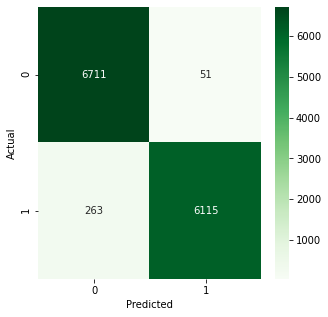

In [ ]:
ar = metrics.confusion_matrix(y_test, y_pred)

conMat = pd.DataFrame(ar, index=[0,1], columns=[0,1])
conMat.index.name = 'Actual'
conMat.columns.name = 'Predicted'

plt.figure(figsize = (5, 5))
sns.heatmap(conMat,cmap= "Greens", annot = True, fmt='')

precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)

print('Recall score: ' + str(round(recall_score, 2)))
print('Precision score: ' + str(round(precision_score, 2)))

# (6) Parameter Tuning

Completed throughout the project

# (7) Prediction

**Import data**

In [ ]:
prediction = pd.read_csv('/content/gdrive/My Drive/Data/prediction.csv')
predictionPrint = pd.read_csv('/content/gdrive/My Drive/Data/prediction.csv')

friend = pd.read_csv('/content/gdrive/My Drive/Data/friendResult.csv')
friendPrint = pd.read_csv('/content/gdrive/My Drive/Data/friendResult.csv')

**Proprocess data**

In [ ]:
prediction['text'] = removeLocPubURL(prediction)
prediction['text'] = lowerCase(prediction)
prediction['text'] = prediction['text'].astype(str).apply(remove_punctuations)
prediction['text'] = prediction['text'].apply(remove_stop_words)
prediction['text'] = prediction['text'].apply(remove_stop_words)
prediction_sequences = tokenizer.texts_to_sequences(prediction.text)
prediction_padded = pad_sequences(prediction_sequences, maxlen=maxLength, padding=paddingType, truncating=truncType)

friend['text'] = removeLocPubURL(friend)
friend['text'] = lowerCase(friend)
friend['text'] = friend['text'].astype(str).apply(remove_punctuations)
friend['text'] = friend['text'].apply(remove_stop_words)
friend['text'] = friend['text'].apply(remove_stop_words)
friend_sequences = tokenizer.texts_to_sequences(friend.text)
friend_padded = pad_sequences(friend_sequences, maxlen=maxLength, padding=paddingType, truncating=truncType)

**Predict using model**

In [ ]:
y_pred = model.predict_classes(prediction_padded)
y_predFriend = model.predict_classes(friend_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def predictions(y_pred, df):
    for i in range(len(y_pred)):
        print()
        print('===============================================================================')
        if y_pred[i] == 0:
            printBold('FAKE NEWS')
        if y_pred[i] == 1:
            printBold('REAL NEWS')
        print()
        printBold('Title:')
        print(df.iloc[i].title)
        printBold('Text:')
        print(df.iloc[i].text)

**Predict on collected samples**

In [ ]:
predictions(y_pred, predictionPrint)

**REAL NEWS**

**Title:**

Hidden Hate: Exposing the roots of anti-Asian racism in Canada


**Text:**

Anti-Asian racism has surged across North America since the COVID-19 pandemic began, but Metro Vancouver has been particularly hard hit. Statistics from the Vancouver Police Department show a 717-per-cent rise in hate crimes against East Asians from 2019 to 2020. A federally-funded study conducted by several groups under the umbrella of the Chinese Canadian National Council for Social Justice found that B.C. has the most reported incidents per capita of any sub-national region in North America. The alarming increase has put many Canadians of East Asian descent on edge. Const. Byron Yee of the Vancouver Police Department has worked in the city’s Chinatown neighbourhood for several years and has seen the hatred firsthand. He said the uptick started last year at the beginning of the pandemic and appears to be heating up again. “In the last couple of months, it seems like things have started increase again,” Yee said. “I’ve had more people approach me talking about fears of the neighbourho

**REAL NEWS**

**Title:**

Indonesia says missing sub sunk, cracked open, killing all 52 members on board


**Text:**

Indonesia’s navy on Saturday declared its missing submarine had sunk and cracked open, killing 53 crew members aboard, after finding items from the vessel over the past two days. Military chief Hadi Tjahjanto said the presence of an oil slick as well as debris near the site where the submarine’s last dive on Wednesday off the island of Bali were clear proof the KRI Nanggala 402 sank. Indonesia earlier considered the vessel to be only missing. Navy Chief Yudo Margono told a press conference in Bali, “If it’s an explosion, it will be in pieces. The cracks happened gradually in some parts when it went down from 300 metres to 400 metres to 500 metres … If there was an explosion, it would be heard by the sonar.” The navy previously said it believes the submarine sank to a depth of 600-700 metres (2,000-2,300 feet), much deeper than its collapse depth of 200 metres (655 feet), at which point water pressure would be greater than the hull could withstand. The cause of the disappearance was sti

**REAL NEWS**

**Title:**

‘It’s over’: India COVID-19 patients suffocate as cases surge during oxygen shortage


**Text:**

Indian authorities scrambled Saturday to get oxygen tanks to hospitals where COVID-19 patients were suffocating amid the world’s worst coronavirus surge, as the government came under increasing criticism for what doctors said was its negligence in the face of a foreseeable public health disaster. For the third day in a row, India set a global daily record of new infections. The 346,786 confirmed cases over the past day brought India’s total to more than 16 million, behind only the United States. The Health Ministry reported another 2,624 deaths in the past 24 hours, pushing India’s COVID-19 fatalities to 189,544. Experts say even those figures are likely an undercount. The government ramped up its efforts to get medical oxygen to hospitals using special Oxygen Express trains, air force planes and trucks to transport tankers, and took measures to exempt critical oxygen supplies from customs taxes. But the crisis in the country of nearly 1.4 billion people was only deepening as overburde

**FAKE NEWS**

**Title:**

Top vaccine scientist warns the world: HALT all covid-19 vaccinations immediately, or “uncontrollable monster” will be unleashed


**Text:**

A top vaccine scientist named Geert Vanden Bossche, who has worked with numerous vaccine corporations and organizations including GAVI, is sounding the alarm over the mass vaccination of populations around the world with covid-19 vaccines. He says covid-19 vaccines are “brilliant” medicine and insists they do work on an individual level, but says they are “the wrong weapon” to be deployed on a global scale when high pressures of infectious pathogens are present. As he tweeted on March 3rd, “I am EXTREMELY concerned about the impact current Covid-19 vaccines will have when increasingly deployed in mass vaccination campaigns conducted in the heat of a pandemic. Read my global WARNING & scientific evidence.” He then gives the following link for his warning: A vaccine industry insider who worked with the Bill & Melinda Gates Foundation Before we get into the presentation and its meaning, let us first take a quick look at the background of Dr. Bossche. A good description is offered by Drybu

**FAKE NEWS**

**Title:**

Vaccines containing mercury are “medical genocide” that target black communities to damage their babies


**Text:**

The evidence is clear that mercury is still being added to some vaccines, in the form of thimerosal, and yet the mainstream media, along with the establishment medical community, continue to cover it up despite what damage is being done to certain ethnic groups. Vaccine truth activist Robert F. Kennedy, Jr., and Oscar-winning actor Robert De Niro, noted in a recent press conference hosted by investigative reporter Sharyl Attkisson that black communities, in particular, are being targeted in a sort of “medical genocide” aimed at harming black babies with mercury-filled vaccines. “It is the black neighborhoods that are getting the thimerosal vaccines,” Kennedy said at the press conference, held Feb. 15 at the National Press Club in Washington, D.C. “And it appears to be that African-Americans are much more susceptible to vaccine injury than other Americans.” Continuing, he said that poor Americans who have to use publicly-funded clinics will get the cheapest vaccines, and those are the o

**FAKE NEWS**

**Title:**

mRNA vaccines may cause your body to churn out PRIONS that “eat your brain” like Mad Cow Disease


**Text:**

The spike protein outer shell of the coronavirus contains “prion-like regions” that give the virus very high adhesion to ACE2 receptors in the human body. This has been documented by a study entitled, “SARS-CoV-2 Prion-Like Domains in Spike Proteins Enable Higher Affinity to ACE2,” published by the Human Microbiology Institute: The presence and unique distribution of prion-like domains in the SARS-CoV-2 receptor-binding domains of the spike protein is particularly interesting, since although the SARS-CoV-2 and SARS-CoV S proteins share the same host cell receptor, angiotensin-converting enzyme 2 (ACE2), SARS-CoV-2 demonstrates a 10- to 20-fold higher affinity for ACE2 The mRNA vaccine works by hijacking your body’s cells and causing them to churn out proteins modeled after the spike proteins in the SARS-cov-2 coronavirus. Since that structure includes prion-like regions, random errors in mRNA sequences — which may be truncated by the human immune system before they reach the ribosomes 

**Predict on friend's news articles**

In [ ]:
predictions(y_predFriend, friendPrint)

**REAL NEWS**

**Title:**

Israel reports 94% drop in symptomatic COVID-19 cases with Pfizer vaccine: study


**Text:**

Israel‘s largest healthcare provider on Sunday reported a 94 per cent drop in symptomatic COVID-19 infections among 600,000 people who received two doses of the Pfizer’s vaccine in the country’s biggest study to date. Health maintenance organization (HMO) Clalit, which covers more than half of all Israelis, said the same group was also 92 per cent less likely to develop severe illness from the virus. The comparison was against a group of the same size, with matching medical histories, who had not received the vaccine. “It shows unequivocally that Pfizer’s coronavirus vaccine is extremely effective in the real world a week after the second dose, just as it was found to be in the clinical study,” said Ran Balicer, Clalit’s chief innovation officer. He added that the data indicates the Pfizer vaccine, which was developed in partnership with Germany’s BioNTech, is even more effective two weeks or more after the second shot.  Researchers at the Weizmann Institute of Science, who have been t

**FAKE NEWS**

**Title:**

At least 60 percent of all new Covid-19 “cases” are occurring in people who were already vaccinated


**Text:**

Dr. Harvey Risch, a professor of epidemiology at Yale University, has calculated that upwards of 60 percent of all new “cases” of the Wuhan coronavirus (Covid-19) are occurring in people who were already “vaccinated” for the disease. “Clinicians have been telling me that more than half of the new Covid cases that they’re treating are people who have been vaccinated,” Risch told Bannon. As we have been warning, the so-called “third wave” of the Chinese Virus will be due to people who were vaccinated contracting and spreading the disease to others. While Americans who buy into the plandemic narrative have been led to believe that the jabs will protect them against serious symptoms should they test “positive,” Risch says that the medical establishment is looking at things a little bit differently. “I think the American public has been sold on the vaccine by the research that shows that they reduce the infection of mild to moderate symptomatic infection by somewhere between 60-90% dependin